# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, recall_score

import itertools
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading data

In [2]:
data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')


print(f"number of rows is: {data.shape[0]}")
print(f"number of cols is: {data.shape[1]}")

number of rows is: 25192
number of cols is: 42


# Preprocessing

In [3]:
# cleaning data


# check for null columns
num_rows = data.shape[0]
null_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
num_null_columns = len(null_columns)
for col in null_columns:
    null_count = data[col].isnull().sum()
    null_percentage = (null_count/num_rows) * 100
    print(f"{col}: {null_count} ({round(null_percentage, 3)}%)")


# check for duplicate rows
num_dups = data.duplicated().sum()
print(f"Number of null columns rows: {num_null_columns}")
print(f"Number of duplicate rows: {num_dups}")


Number of null columns rows: 0
Number of duplicate rows: 0


In [4]:
old_num_rows = num_rows


# no need to do more preprocessing because the dataset is good
# clean the data (rows with NaN values will be removed)
data = data.dropna()
data = data.dropna(axis=1)


# clean the duplicates
data.drop_duplicates(inplace=True)

print(f"droped number of cols is: {old_num_rows - data.shape[0]}")

droped number of cols is: 0


<Axes: xlabel='count', ylabel='class'>

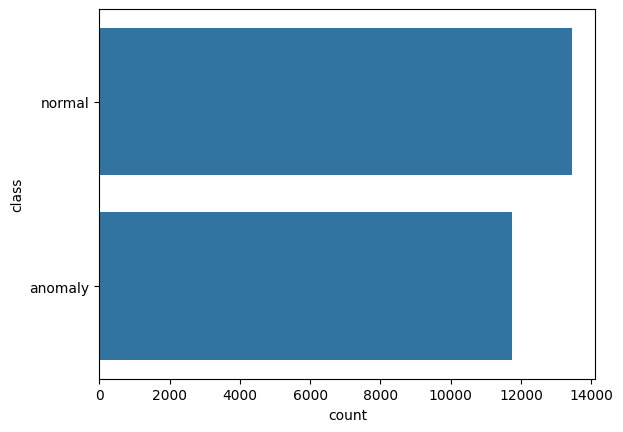

In [5]:
sb.countplot(data=data['class'])

# SMOTE oversampleing (optional)(because our data categories are closely matched)

In [6]:
# not sure if i should do SMOTE oversampling (no need might test it later to see the diffrence in results)

# Encoding the categorical variables (both data and test data)

In [7]:
for col in data.columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

for col in test_data.columns:
    if test_data[col].dtype == 'object':
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col])

# Recursive Feature Elimination (selecting features to use)

In [8]:
# find the top10 most usefull features
x = data.drop("class", axis=1)
y = data["class"]

rf_model = RandomForestClassifier()

rfe = RFE(rf_model, n_features_to_select=10)
rfe = rfe.fit(x, y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), x.columns)]
selected_features = [v for i, v in feature_map if i==True]

print("selected features are: ", selected_features)

x = x[selected_features]

selected features are:  ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']


# feature importance classification

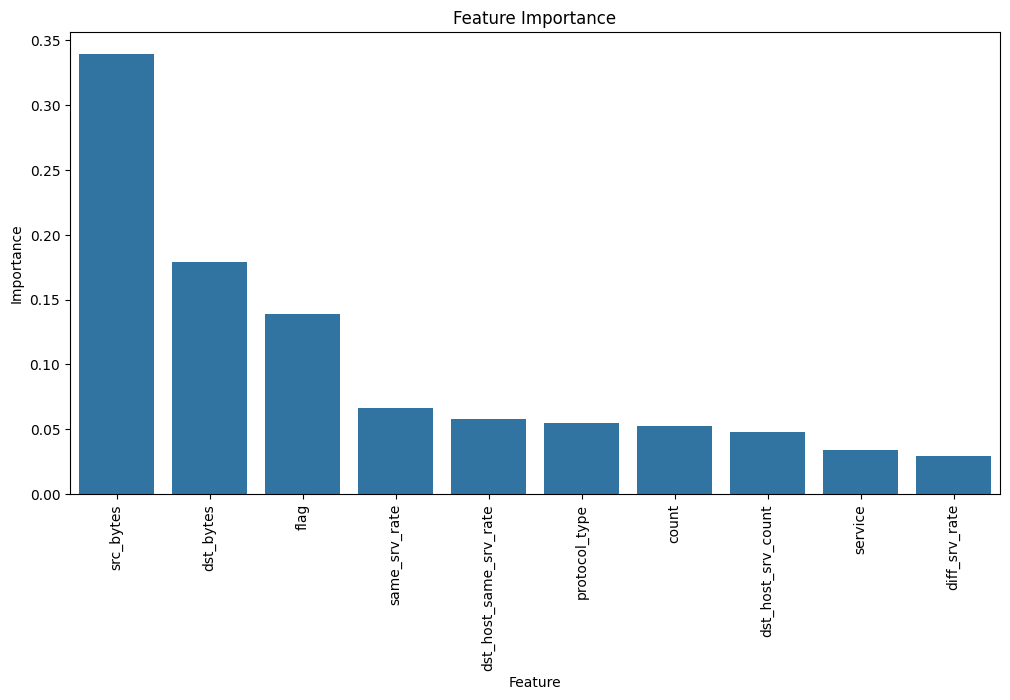

In [9]:
rf_model = RandomForestClassifier()
rf_model.fit(x[selected_features], y)

feature_importances = rf_model.feature_importances_

feature_importance_map = dict(zip(selected_features, feature_importances))

sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

features, importances = zip(*sorted_features)

plt.figure(figsize=(12, 6))
sb.barplot(x=features, y=importances)

plt.xticks(rotation=90)

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.show()

# Standerization of feature data

In [10]:
scale = StandardScaler()
x = scale.fit_transform(x)
# test_data = scale.fit_transform(test_data)

# spliting training data

In [11]:
print("old values:")
print("\t", x.shape)
print("\t", y.shape)

# spliting training and testing data (80% training, 20% testing)
x, x_test, y, y_test = train_test_split(x, y, train_size=0.80, random_state=2)

print("new training values:")
print("\t", x.shape)
print("\t", y.shape)

print("new testing values:")
print("\t", x_test.shape)
print("\t", y_test.shape)

old values:
	 (25192, 10)
	 (25192,)
new training values:
	 (20153, 10)
	 (20153,)
new testing values:
	 (5039, 10)
	 (5039,)


# Training

## Logistic Regression algorithme

In [12]:
# KNeighborsClassifier(n_neighbors=26)
# LogisticRegression(max_iter = 20000000)
no_optuna_lr_model = LogisticRegression(max_iter = 20000000)
no_optuna_lr_model = LogisticRegression(random_state = 42)

print("WITHOUT optuna hyperparameter optimization")
start_time = time.time()
no_optuna_lr_model.fit(x, y)
end_time = time.time()
print("\tTraining time: ", end_time-start_time)

start_time = time.time()
testing_predection = no_optuna_lr_model.predict(x)
end_time = time.time()
print("\tTesting time: ", end_time-start_time)


lr_score = no_optuna_lr_model.score(x, y)
lr_test_score = no_optuna_lr_model.score(x_test, y_test)


lr_no_optuna_score= no_optuna_lr_model.score(x, y)
lr_no_optuna_test_score= no_optuna_lr_model.score(x_test, y_test)

print("\ttraining score : ", lr_no_optuna_score)
print("\ttesting  score : ", lr_no_optuna_test_score)


print("#############################################")
print("#############################################")
print("#############################################")
print("#############################################")

print("WITH optuna hyperparameter optimization")

def logistic_regression(trial):
    lr_max_iter = trial.suggest_int('lr_max_iter', 100000, 20000000, log=False)
    lr_random_states = trial.suggest_int('lr_random_states', 10, 50, log=False)
    classifier_obj = LogisticRegression(max_iter = lr_max_iter, random_state = lr_random_states)
    classifier_obj.fit(x, y)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy
    

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(logistic_regression, n_trials=30)


lr_model = LogisticRegression(max_iter = study_lr.best_trial.params['lr_max_iter'], random_state = study_lr.best_trial.params['lr_random_states'])
lr_model.fit(x, y)

lr_score, lr_test_score = lr_model.score(x, y), lr_model.score(x_test, y_test)

print(f"\tTrain Score: {lr_score}")
print(f"\tTest Score: {lr_test_score}")


WITHOUT optuna hyperparameter optimization
	Training time:  0.024483442306518555
	Testing time:  0.0008883476257324219
	training score :  0.9294894060437652
	testing  score :  0.9192300059535622
#############################################
#############################################
#############################################
#############################################
WITH optuna hyperparameter optimization
	Train Score: 0.9294894060437652
	Test Score: 0.9192300059535622


## K Neighbors Classifier

In [13]:
no_optuna_KKN_model = KNeighborsClassifier(n_neighbors=26)
start_time = time.time()
no_optuna_KKN_model.fit(x, y.values.ravel())
end_time = time.time()
print("WITHOUT optuna hyperparameter optimization")
print("\tTraining time: ", end_time-start_time)


start_time = time.time()
y_test_pred = no_optuna_KKN_model.predict(x)
end_time = time.time()
print("\tTesting time: ", end_time-start_time)


KNN_no_optuna_score= no_optuna_KKN_model.score(x, y)
KNN_no_optuna_test_score= no_optuna_KKN_model.score(x_test, y_test)


print("\ttraining score : ", KNN_no_optuna_score)
print("\ttesting  score : ", KNN_no_optuna_test_score)

print("####################################")
print("####################################")

print("WITH optuna hyperparameter optimization")

def knn_func(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x, y)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(knn_func, n_trials=1)


KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x, y)

KNN_train, KNN_test = KNN_model.score(x, y), KNN_model.score(x_test, y_test)

print(f"\tTrain Score: {KNN_train}")
print(f"\tTest Score: {KNN_test}")


WITHOUT optuna hyperparameter optimization
	Training time:  0.05600428581237793
	Testing time:  2.623974323272705
	training score :  0.9763806877387982
	testing  score :  0.975590394919627
####################################
####################################
WITH optuna hyperparameter optimization
	Train Score: 0.9877933806381184
	Test Score: 0.9833300257987696


## Decision Tree Classifier

In [14]:
no_optuna_dt_model = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
no_optuna_dt_model.fit(x, y.values.ravel())
end_time = time.time()
print("\tTraining time: ", end_time-start_time)


start_time = time.time()
y_test_pred = no_optuna_dt_model.predict(x)
end_time = time.time()
print("\tTesting time: ", end_time-start_time)


dt_no_optuna_score= no_optuna_dt_model.score(x, y)
dt_no_optuna_test_score= no_optuna_dt_model.score(x_test, y_test)

print("\ttraining score : ", dt_no_optuna_score)
print("\ttesting  score : ", dt_no_optuna_test_score)

print("####################################")
print("####################################")
print("####################################")
print("####################################")

print("WITH optuna hyperparameter optimization")
def tree_search(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x, y)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy
    

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(tree_search, n_trials=30)
print("\t", study_dt.best_trial)


dt_model = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt_model.fit(x, y)

dt_score, dt_test_score = dt_model.score(x, y), dt_model.score(x_test, y_test)

print(f"\tTrain Score: {dt_score}")
print(f"\tTest Score: {dt_test_score}")

	Training time:  0.024876832962036133
	Testing time:  0.0009968280792236328
	training score :  0.9803006996476952
	testing  score :  0.977971819805517
####################################
####################################
####################################
####################################
WITH optuna hyperparameter optimization
	 FrozenTrial(number=12, state=1, values=[0.9966263147449891], datetime_start=datetime.datetime(2024, 5, 29, 21, 30, 37, 606286), datetime_complete=datetime.datetime(2024, 5, 29, 21, 30, 37, 649897), params={'dt_max_depth': 25, 'dt_max_features': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=12, value=None)
	Train Score: 1.0
	Test Score: 0.9948402460805715


# Comparison

In [15]:
from tabulate import tabulate

data1 = [
        ["Logistic Regression no optuna", lr_no_optuna_score, lr_no_optuna_test_score],
        ["Logistic Regression", lr_score, lr_test_score]
        ]
data2 = [
        ["KNN no optuna", KNN_no_optuna_score, KNN_no_optuna_test_score], 
        ["KNN", KNN_train, KNN_test]
        ]
data3 = [
        ["Decision Tree no optuna", dt_no_optuna_score, dt_no_optuna_test_score],
        ["Decision Tree", dt_score, dt_test_score]
]


col_names = ["Model", "Train Score", "Test Score"]
print("table of LogisticRegression training")
print(tabulate(data1, headers=col_names, tablefmt="fancy_grid"))
print("table of KNeighborsClassifier training")
print(tabulate(data2, headers=col_names, tablefmt="fancy_grid"))
print("table of DecisionTreeClassifier training")
print(tabulate(data3, headers=col_names, tablefmt="fancy_grid"))

table of LogisticRegression training
╒═══════════════════════════════╤═══════════════╤══════════════╕
│ Model                         │   Train Score │   Test Score │
╞═══════════════════════════════╪═══════════════╪══════════════╡
│ Logistic Regression no optuna │      0.929489 │      0.91923 │
├───────────────────────────────┼───────────────┼──────────────┤
│ Logistic Regression           │      0.929489 │      0.91923 │
╘═══════════════════════════════╧═══════════════╧══════════════╛
table of KNeighborsClassifier training
╒═══════════════╤═══════════════╤══════════════╕
│ Model         │   Train Score │   Test Score │
╞═══════════════╪═══════════════╪══════════════╡
│ KNN no optuna │      0.976381 │      0.97559 │
├───────────────┼───────────────┼──────────────┤
│ KNN           │      0.987793 │      0.98333 │
╘═══════════════╧═══════════════╧══════════════╛
table of DecisionTreeClassifier training
╒═════════════════════════╤═══════════════╤══════════════╕
│ Model                   

## Calculating Precesion and recall scores

scoring  insta generated LogisticRegression . . . .
scoring  has some params LogisticRegression . . . .
scoring  hyperparamerts optimized with opruna LogisticRegression . . . .
scoring  insta generated KNeighborsClassifier . . . .
scoring  has some params KNeighborsClassifier . . . .
scoring  hyperparamerts optimized with opruna KNeighborsClassifier . . . .
scoring  insta generated DecisionTreeClassifier . . . .
scoring  has some params DecisionTreeClassifier . . . .
scoring  hyperparamerts optimized with opruna DecisionTreeClassifier . . . .

#############################################
insta generated LogisticRegression Model Validation

	Mean precision: 
	 91.389 % +- 0.60277
	Mean recall: 
	 95.76467 % +- 0.63871

#############################################
has some params LogisticRegression Model Validation

	Mean precision: 
	 91.389 % +- 0.60277
	Mean recall: 
	 95.76467 % +- 0.63871

#############################################
hyperparamerts optimized with opruna LogisticR

<Axes: >

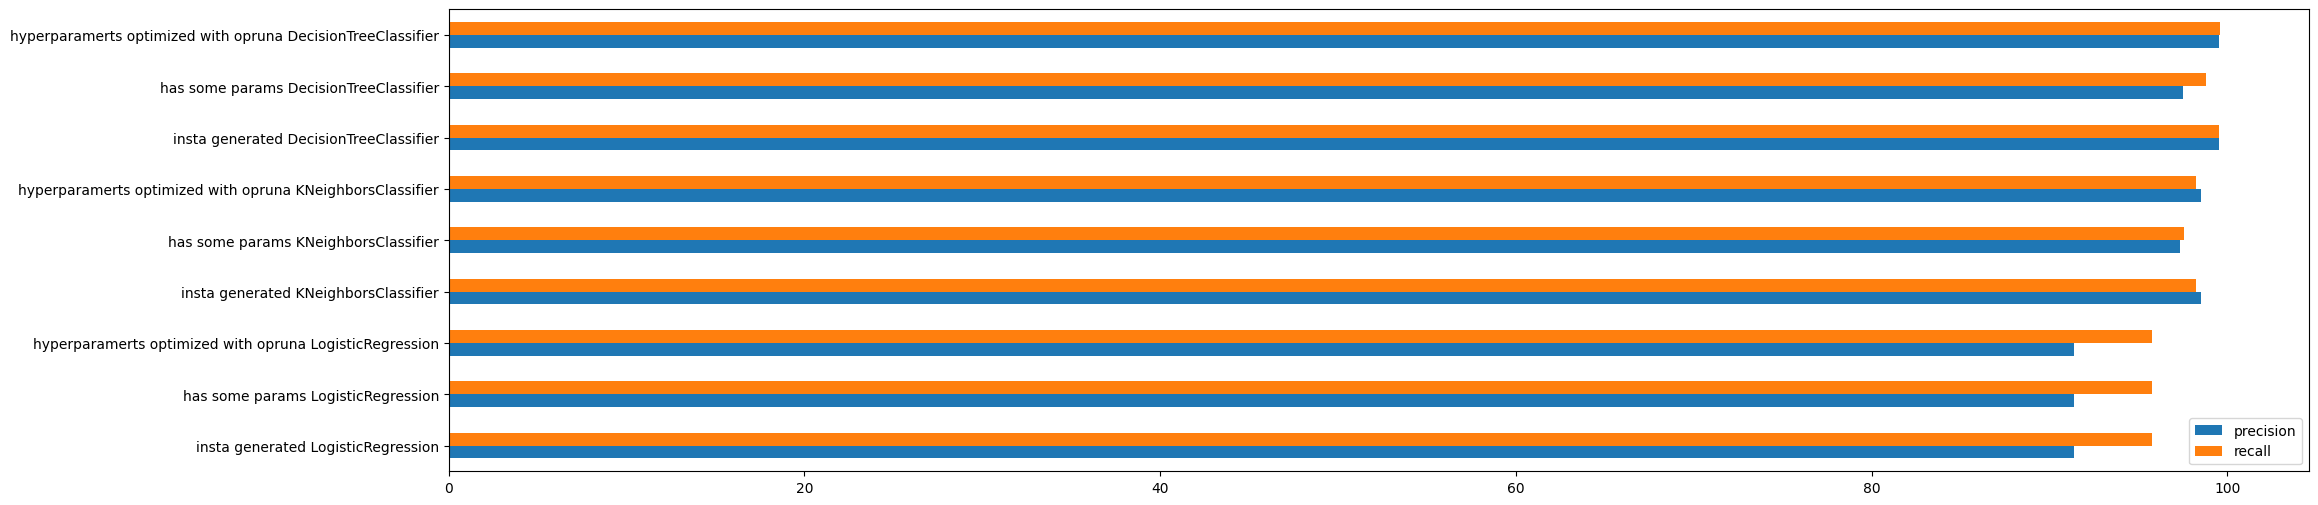

In [16]:
models = {
    'insta generated LogisticRegression': LogisticRegression(), 
    'has some params LogisticRegression': no_optuna_lr_model,
    'hyperparamerts optimized with opruna LogisticRegression': lr_model,

    'insta generated KNeighborsClassifier': KNeighborsClassifier(), 
    'has some params KNeighborsClassifier': no_optuna_KKN_model,
    'hyperparamerts optimized with opruna KNeighborsClassifier': KNN_model,

    'insta generated DecisionTreeClassifier': DecisionTreeClassifier(),
    'has some params DecisionTreeClassifier': no_optuna_dt_model,
    'hyperparamerts optimized with opruna DecisionTreeClassifier': dt_model
    }

# calculating precesion and recall score
scores = {}
for m in models:
    print("scoring ", m, ". . . .")
    scores[m]={}
    for scorer in ['precision','recall']:
        scores[m][scorer] = cross_val_score(models[m], x, y, cv=10, scoring=scorer)


# calculating precesion and recall mean
import sys
for m in models:
    print("\n#############################################")
    print(m, 'Model Validation\n')
    for scorer in ['precision','recall']:
        mean = round(np.mean(scores[m][scorer])*100,5)
        stdev = round(np.std(scores[m][scorer])*100,5)
        print ("\tMean {}:".format(scorer),"\n\t", mean,"%", "+-",stdev)

# Compaing precesion and recall scores (plot)
for m in models:
    for scorer in ['precision','recall']:
        scores[m][scorer] = scores[m][scorer].mean()
scores=pd.DataFrame(scores).transpose()*100
scores.plot(kind = "barh",  ylim=[80,100], figsize=(24,6), rot=0)

## Validation

In [17]:
models = {
    'insta generated LogisticRegression': LogisticRegression(), 
    'has some params LogisticRegression': no_optuna_lr_model,
    'hyperparamerts optimized with opruna LogisticRegression': lr_model,

    'insta generated KNeighborsClassifier': KNeighborsClassifier(), 
    'has some params KNeighborsClassifier': no_optuna_KKN_model,
    'hyperparamerts optimized with opruna KNeighborsClassifier': KNN_model,

    'insta generated DecisionTreeClassifier': DecisionTreeClassifier(),
    'has some params DecisionTreeClassifier': no_optuna_dt_model,
    'hyperparamerts optimized with opruna DecisionTreeClassifier': dt_model
    }



preds={}
for name in models:
    models[name].fit(x, y)
    preds[name] = models[name].predict(x_test)
print("Predictions complete.")




target_names=["normal","anamoly"]
for name in models:
    print("\n#############################################")
    print("\n", name, 'Model Testing')
    print(confusion_matrix(y_test, preds[name]))
    print("\n--------------------------------------------")
    print(classification_report(y_test, preds[name], target_names=target_names))


Predictions complete.

#############################################

 insta generated LogisticRegression Model Testing
[[2070  263]
 [ 144 2562]]

--------------------------------------------
              precision    recall  f1-score   support

      normal       0.93      0.89      0.91      2333
     anamoly       0.91      0.95      0.93      2706

    accuracy                           0.92      5039
   macro avg       0.92      0.92      0.92      5039
weighted avg       0.92      0.92      0.92      5039


#############################################

 has some params LogisticRegression Model Testing
[[2070  263]
 [ 144 2562]]

--------------------------------------------
              precision    recall  f1-score   support

      normal       0.93      0.89      0.91      2333
     anamoly       0.91      0.95      0.93      2706

    accuracy                           0.92      5039
   macro avg       0.92      0.92      0.92      5039
weighted avg       0.92      0.92    

# plots

<Axes: >

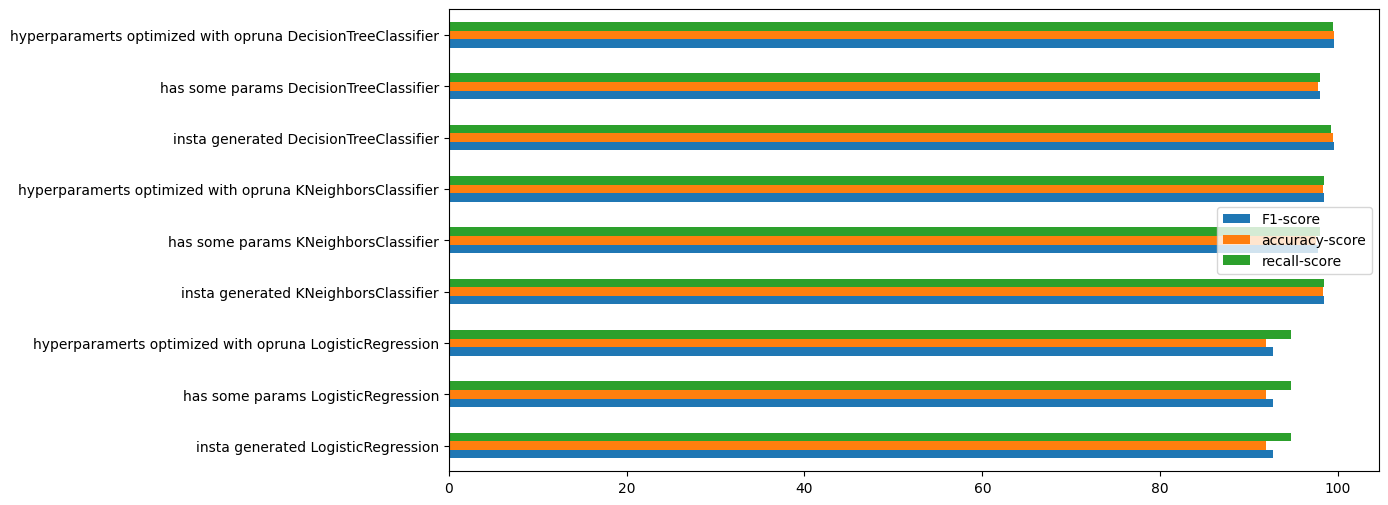

In [18]:
bars = {}
for name in models:
    bars[name]= [f1_score(y_test, preds[name]), accuracy_score(y_test, preds[name]), recall_score(y_test, preds[name])]
bars1=pd.DataFrame(bars.values(),index=bars.keys(),columns=["F1-score", "accuracy-score", "recall-score"])*100
bars1.plot(kind = "barh",  ylim=[80,100], figsize=(12,6), rot=0)

In [64]:
new_input = pd.read_csv("ok.csv")


for col in new_input:
    if new_input[col].dtype == 'object':
        le = LabelEncoder()
        new_input[col] = le.fit_transform(new_input[col])


#print(new_input)


new_input = new_input[selected_features]






print(no_optuna_lr_model.predict(new_input))
print(lr_model.predict(new_input))

print(no_optuna_KKN_model.predict(new_input))
print(KNN_model.predict(new_input))

print(no_optuna_dt_model.predict(new_input))
print(dt_model.predict(new_input))

#   LogisticRegression(), 
#   no_optuna_lr_model,
#   lr_model,
#
#   KNeighborsClassifier(), 
#   no_optuna_KKN_model,
#   KNN_model,
#
#   DecisionTreeClassifier(),
#   no_optuna_dt_model,
#   dt_model



[1 0 1 0 1]
[1 0 1 0 1]
[1 0 0 0 0]
[0 0 0 0 0]
[1 1 1 1 1]
[1 1 1 0 1]


c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
